In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
from datetime import date, timedelta
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")

# set plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['figure.dpi'] = 400

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.metrics as metrics
from sklearn import preprocessing

In [2]:
import joblib

# load saved model
lr_model = joblib.load('corona_model.pkl')

# get optimal window from file
with open('window.txt', 'r') as file:
    OPTIMAL_WINDOW = int(file.readline())

In [3]:
def create_dataset(data, window):
    """ Create a dataset using a sliding window over the given data.
    
    Params:
        data (numpy: T): array with case number time series.
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        x (numpy: T' x W): array with T' samples (T'=T-W), each with W values (window size)
    """
    dataX, dataY = [], []
    for i in range(len(data)-window): # !!!!!! IMPORTANT: CHANGED THIS LINE (WAS IT A BUG?)
        a = data[i:(i+window)]
        dataX.append(a)
        dataY.append(data[i + window])
    return np.array(dataX), np.array(dataY)

# Compute growth rate timeseries per city

In [4]:
df_city_infected_growth = pd.read_csv('city.csv')

corona_score_growth = {}

for index, row in df_city_infected_growth.iterrows():
    # get city df
    selected_city = row['city']
    
    df_selected_city = df_city_infected_growth.loc[df_city_infected_growth['city'] == selected_city]


    # get numpy array per city
    df_numpy = df_selected_city.drop('city', axis=1)
    selected_city_arr = df_numpy.to_numpy()[0]
    selected_city_removed_arr = np.delete(selected_city_arr, 0)
    selected_city_test_x, selected_city_test_y = create_dataset(selected_city_removed_arr[:100], OPTIMAL_WINDOW)

    # predict per city
    selected_city_predictions = lr_model.predict(selected_city_test_x)

    test = selected_city_predictions

    growth_rate_list = []
    for i, prediction in enumerate(test):
        if (i == 0):
            continue
        growth_rate = (abs(test[i] - test[i-1]) / test[i-1]) * 100.0
        growth_rate_list.append(growth_rate)
            
    norm_growth_rate_list = (growth_rate_list - min(growth_rate_list)) / (max(growth_rate_list) - min(growth_rate_list)) * 100
    corona_score_growth[selected_city] = norm_growth_rate_list[1:15]
    
df_corona_score_growth = pd.DataFrame.from_dict(corona_score_growth, orient='index')
df_corona_score_growth = df_corona_score_growth.reset_index()
df_corona_score_growth.rename(columns={ df_corona_score_growth.columns[0]: "city" }, inplace = True)
df_corona_score_growth

,city,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Munich,30.504684,51.750033,66.512521,76.755088,83.855364,88.775365,92.184527,94.547610,96.186736,97.324932,98.116504,98.668147,99.053628,99.323941
1,Zurich,29.571757,50.240192,64.668266,74.739809,81.777524,86.705754,90.168156,92.612011,94.347641,95.590179,96.488771,97.146727,97.635699,98.005371
2,Montpellier,26.440940,45.169820,58.470583,67.962003,74.783358,79.732834,83.367766,86.076868,88.130856,89.718395,90.971054,91.980893,92.812280,93.510637
3,Barcelona,30.492639,51.730550,66.488752,76.729147,83.828668,88.748825,92.158733,94.522923,96.163364,97.302986,98.096020,98.649120,99.036031,99.307722
4,Lyon,29.821371,50.644319,65.162088,75.279595,82.334272,87.260531,90.708940,93.131431,94.841508,96.056431,96.926661,97.556485,98.018090,98.361523
5,Geneva,30.463458,51.683373,66.431182,76.666312,83.763977,88.684506,92.096204,94.463051,96.106650,97.249682,98.046214,98.602811,98.993135,99.268122
6,Alsance,28.522324,48.541046,62.591938,72.469750,79.435680,84.371650,87.892460,90.425642,92.268287,93.626751,94.644255,95.420319,96.024125,96.504007
7,Avignon,20.619764,35.726422,46.907950,55.295290,61.690248,66.657643,70.595171,73.782705,76.417418,78.638255,80.544240,82.205530,83.672894,84.983092
8,Pyrenees,8.337219,15.470605,21.688885,27.201639,32.160086,36.674467,40.824181,44.667579,48.246095,51.591332,54.726459,57.670100,60.436014,63.036408
9,Ceveness,6.197535,11.750222,16.805516,21.472419,25.827701,29.925870,33.805069,37.492044,41.005695,44.358759,47.560820,50.618200,53.535718,56.317772


In [5]:
df_corona_score_growth

,city,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Munich,30.504684,51.750033,66.512521,76.755088,83.855364,88.775365,92.184527,94.547610,96.186736,97.324932,98.116504,98.668147,99.053628,99.323941
1,Zurich,29.571757,50.240192,64.668266,74.739809,81.777524,86.705754,90.168156,92.612011,94.347641,95.590179,96.488771,97.146727,97.635699,98.005371
2,Montpellier,26.440940,45.169820,58.470583,67.962003,74.783358,79.732834,83.367766,86.076868,88.130856,89.718395,90.971054,91.980893,92.812280,93.510637
3,Barcelona,30.492639,51.730550,66.488752,76.729147,83.828668,88.748825,92.158733,94.522923,96.163364,97.302986,98.096020,98.649120,99.036031,99.307722
4,Lyon,29.821371,50.644319,65.162088,75.279595,82.334272,87.260531,90.708940,93.131431,94.841508,96.056431,96.926661,97.556485,98.018090,98.361523
5,Geneva,30.463458,51.683373,66.431182,76.666312,83.763977,88.684506,92.096204,94.463051,96.106650,97.249682,98.046214,98.602811,98.993135,99.268122
6,Alsance,28.522324,48.541046,62.591938,72.469750,79.435680,84.371650,87.892460,90.425642,92.268287,93.626751,94.644255,95.420319,96.024125,96.504007
7,Avignon,20.619764,35.726422,46.907950,55.295290,61.690248,66.657643,70.595171,73.782705,76.417418,78.638255,80.544240,82.205530,83.672894,84.983092
8,Pyrenees,8.337219,15.470605,21.688885,27.201639,32.160086,36.674467,40.824181,44.667579,48.246095,51.591332,54.726459,57.670100,60.436014,63.036408
9,Ceveness,6.197535,11.750222,16.805516,21.472419,25.827701,29.925870,33.805069,37.492044,41.005695,44.358759,47.560820,50.618200,53.535718,56.317772


In [6]:
df_corona_score_growth.to_csv('city_corona_score_growth.csv', index=False)

# Plot infected

Munich


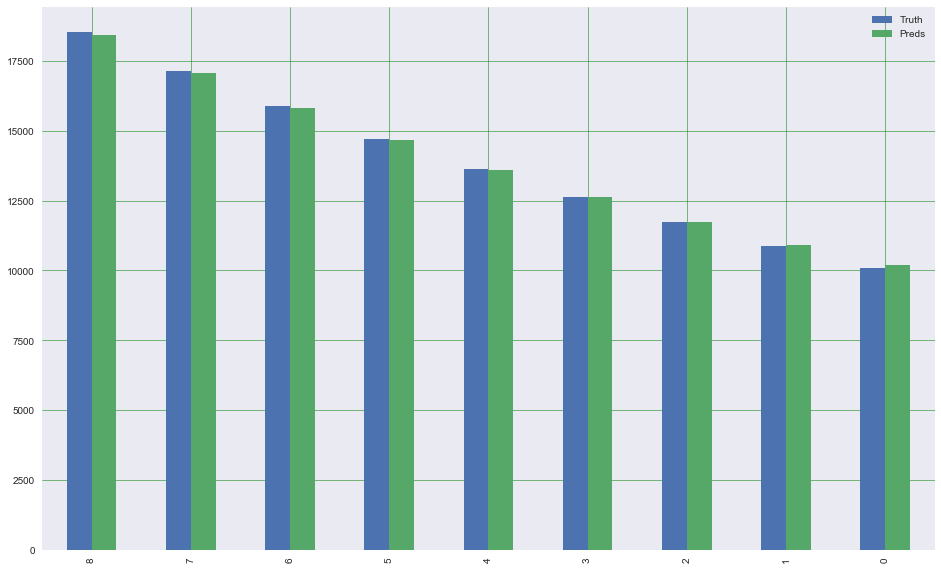

Zurich


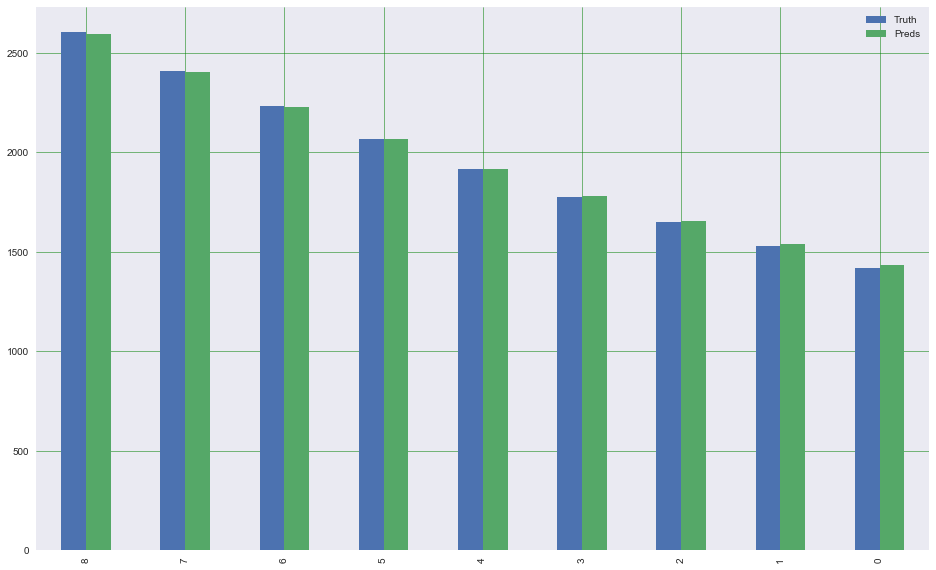

Montpellier


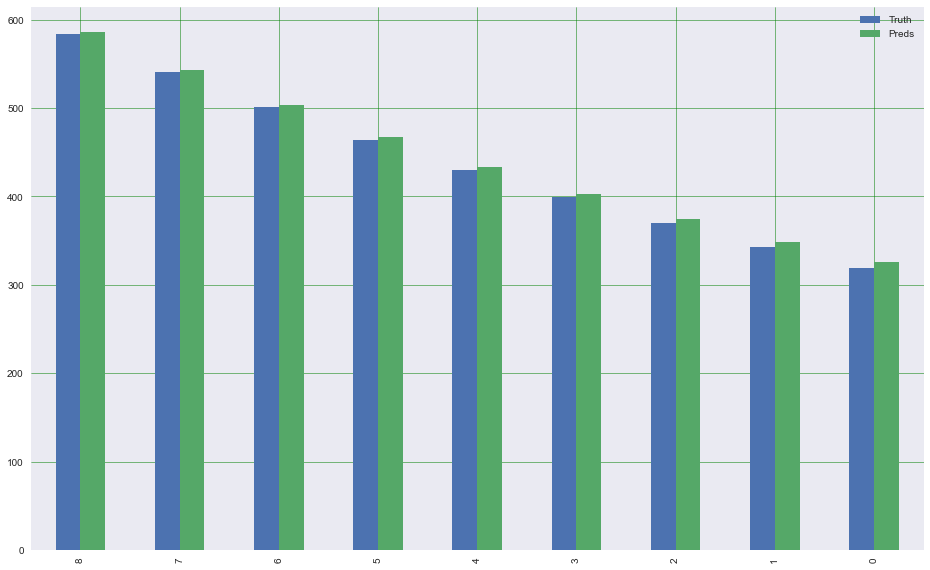

Barcelona


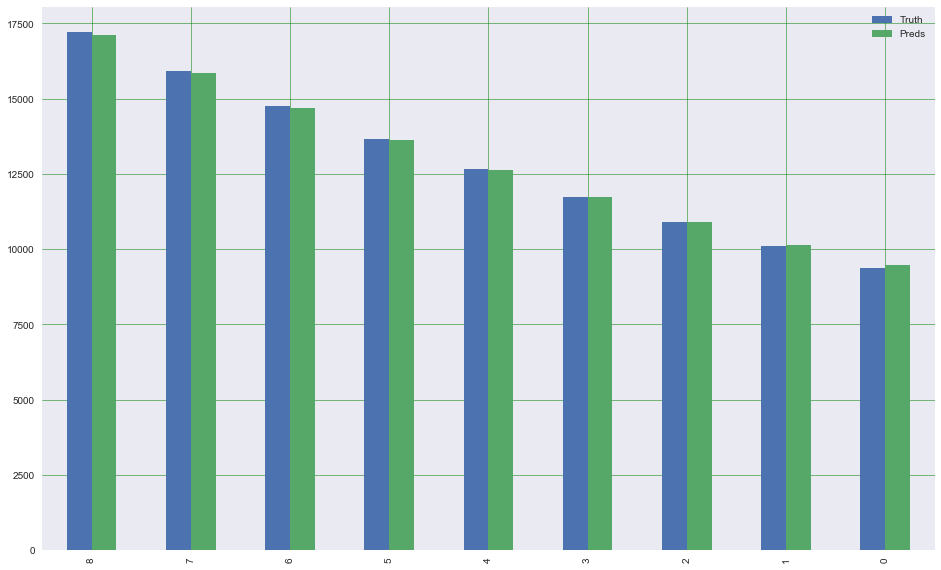

Lyon


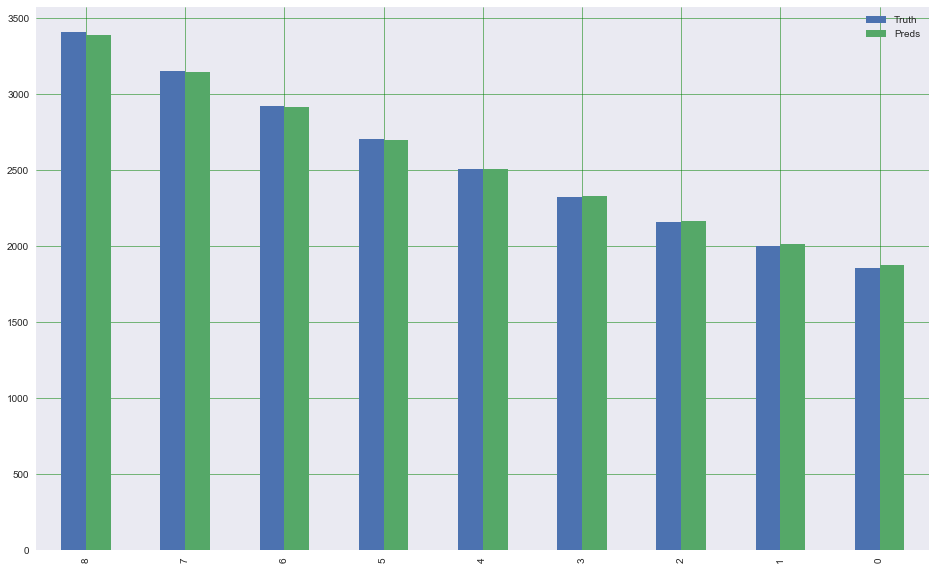

Geneva


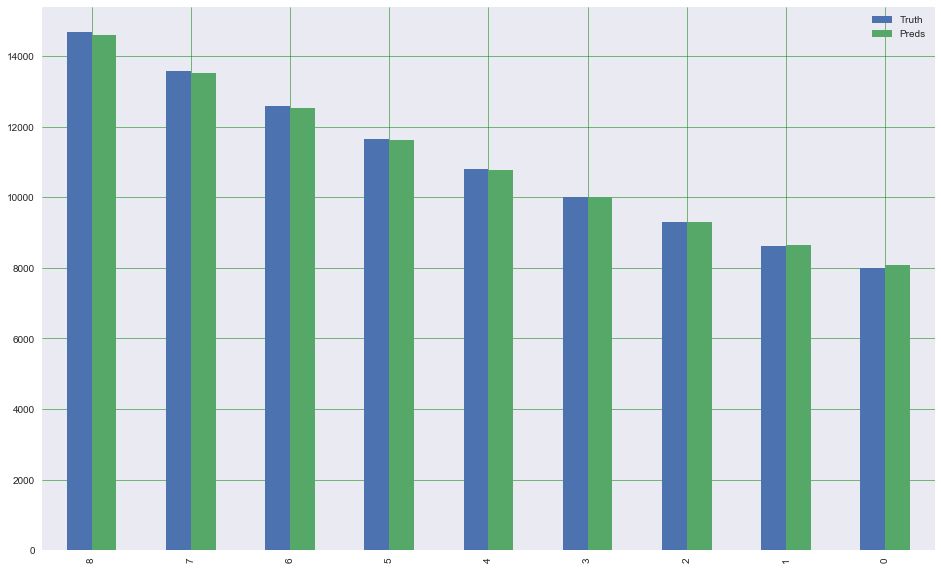

Alsance


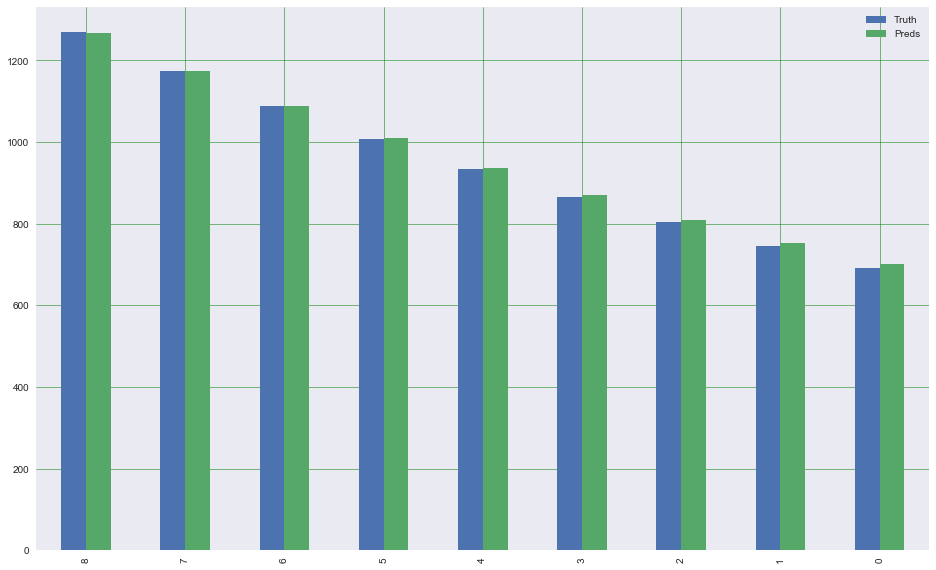

Avignon


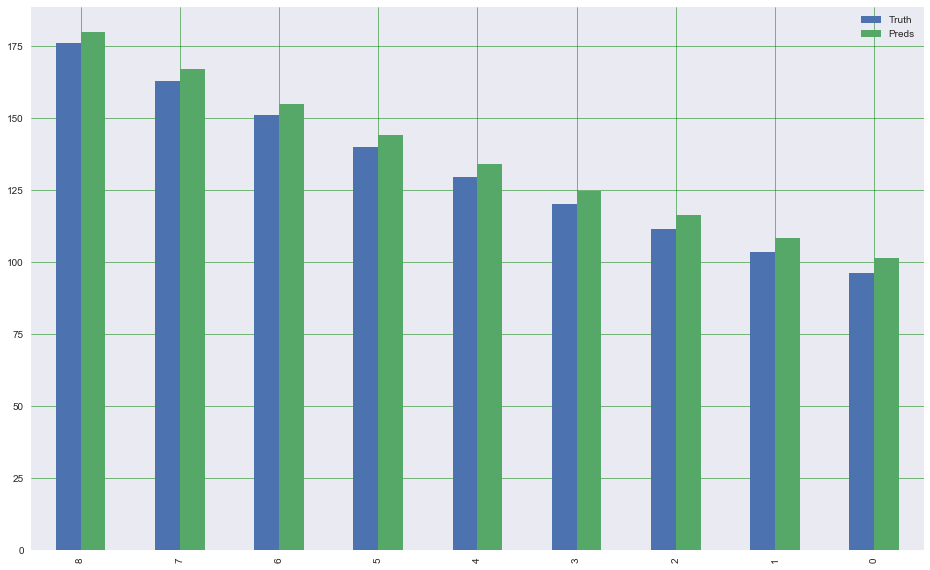

Pyrenees


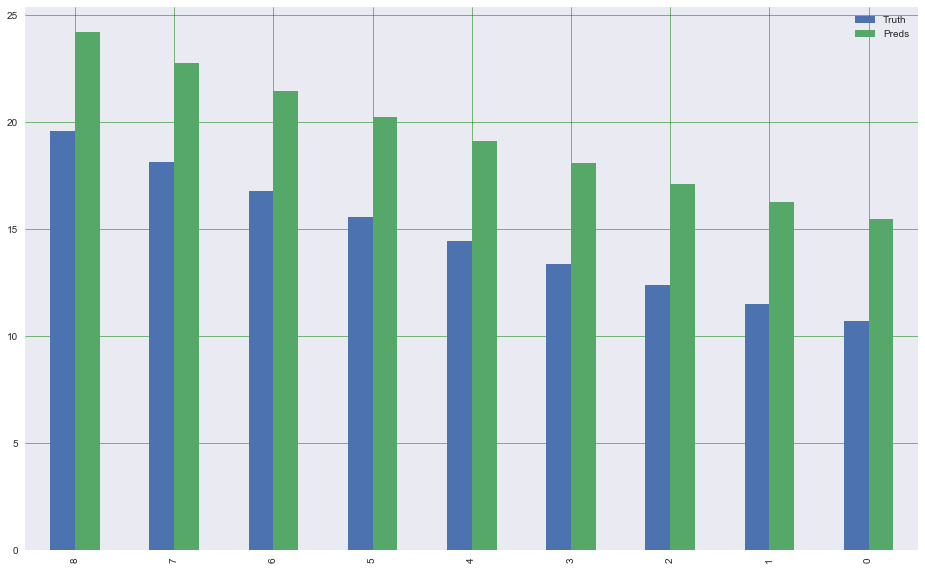

Ceveness


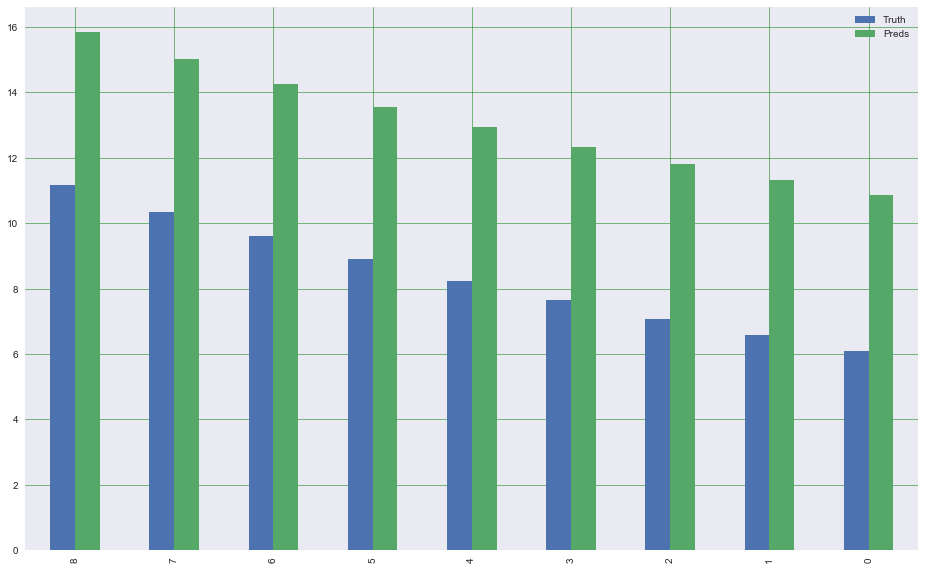

Black forest


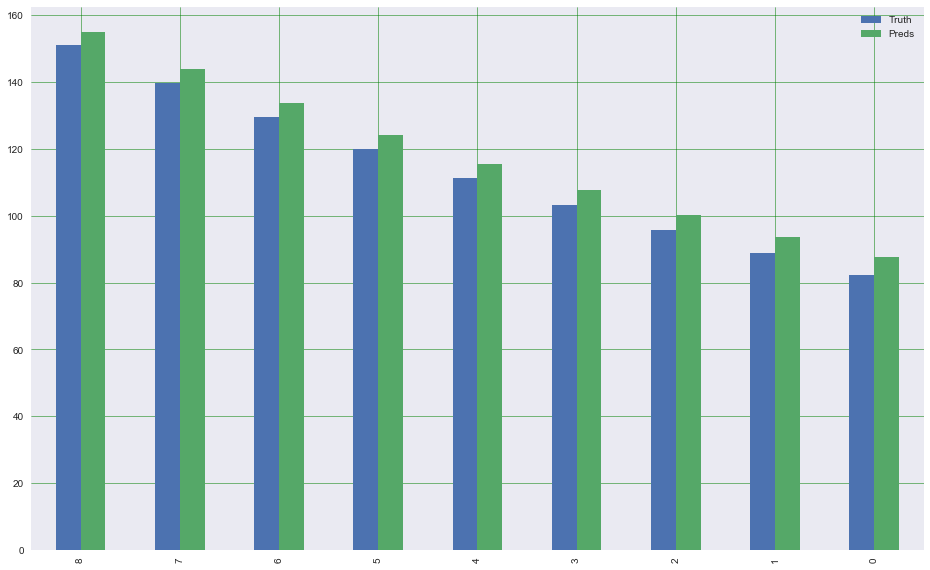

Mayrhofen


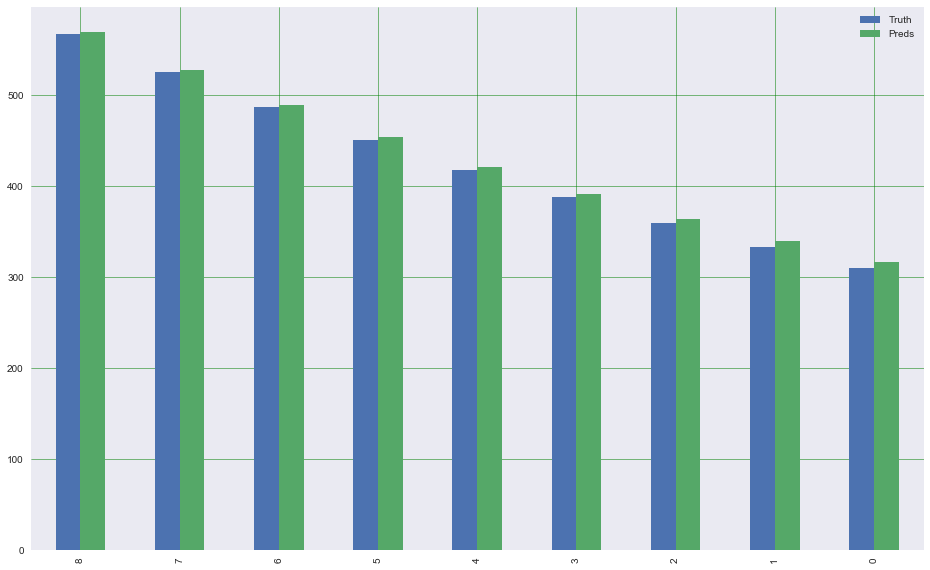

Bozen


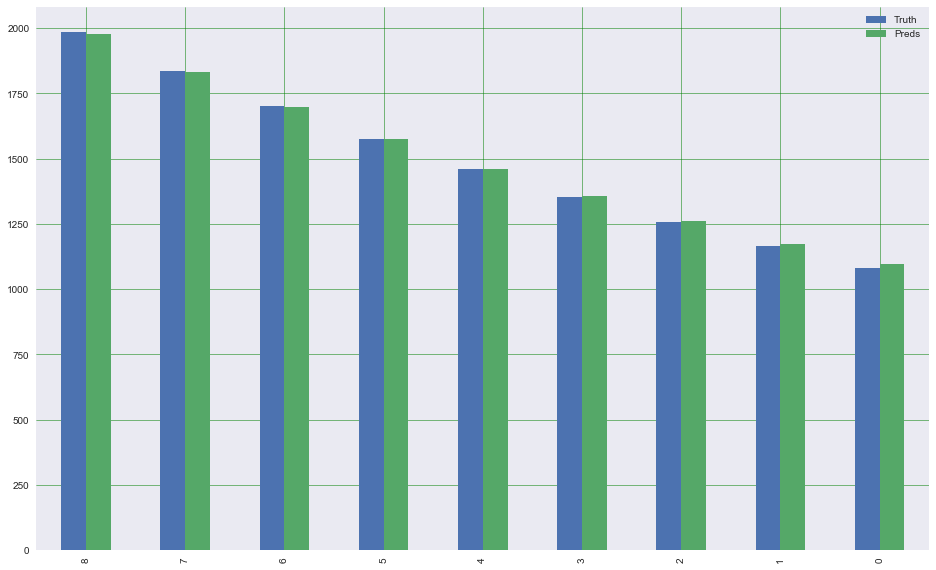

Castellane


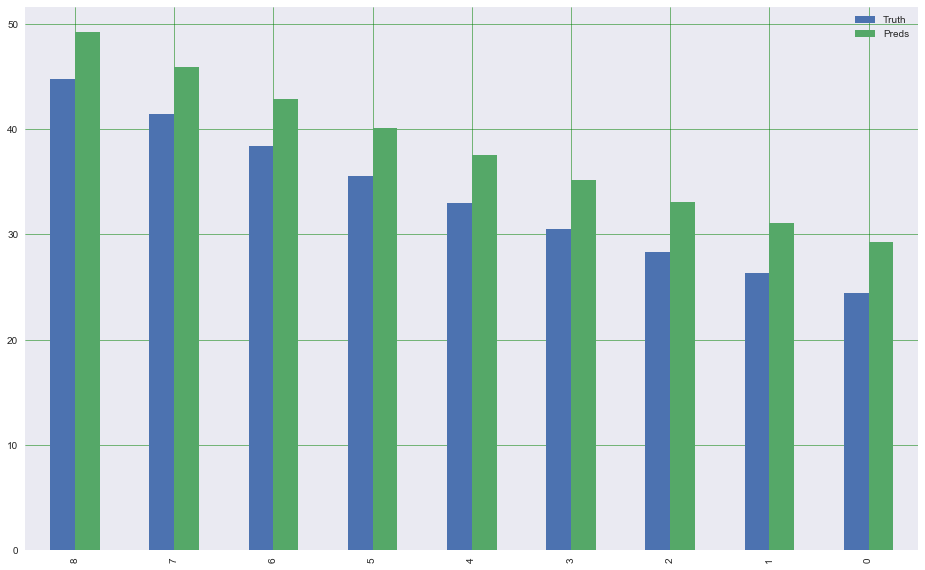

Girona


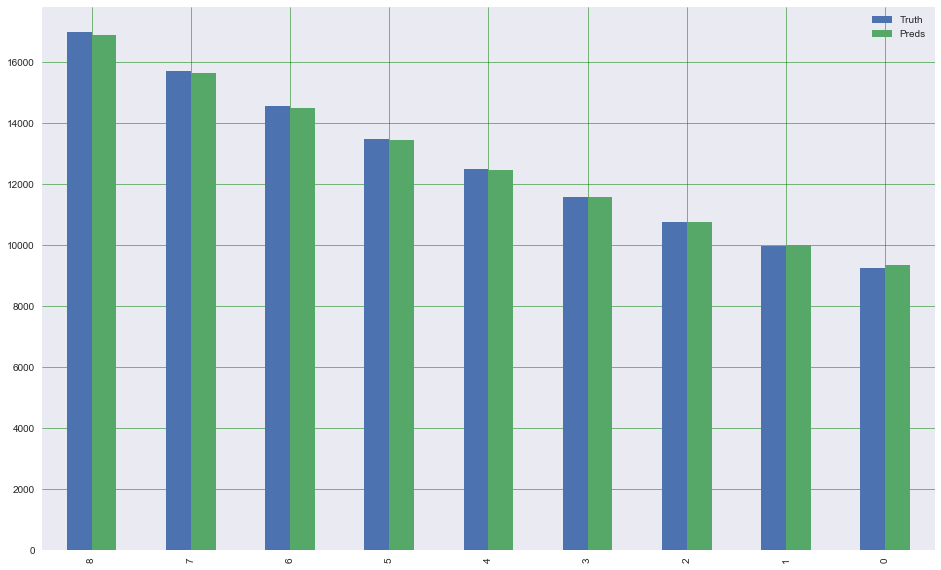

Rodez


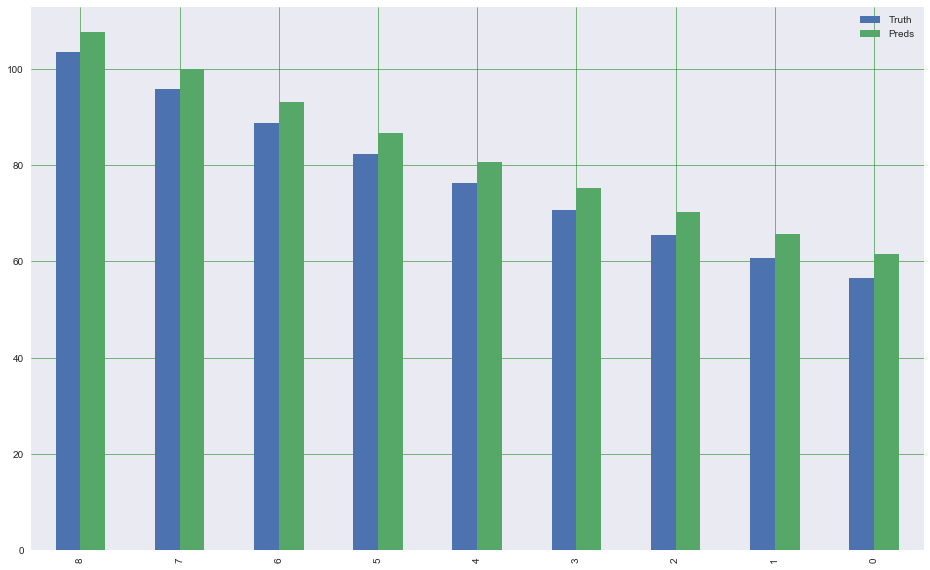

Charmonix


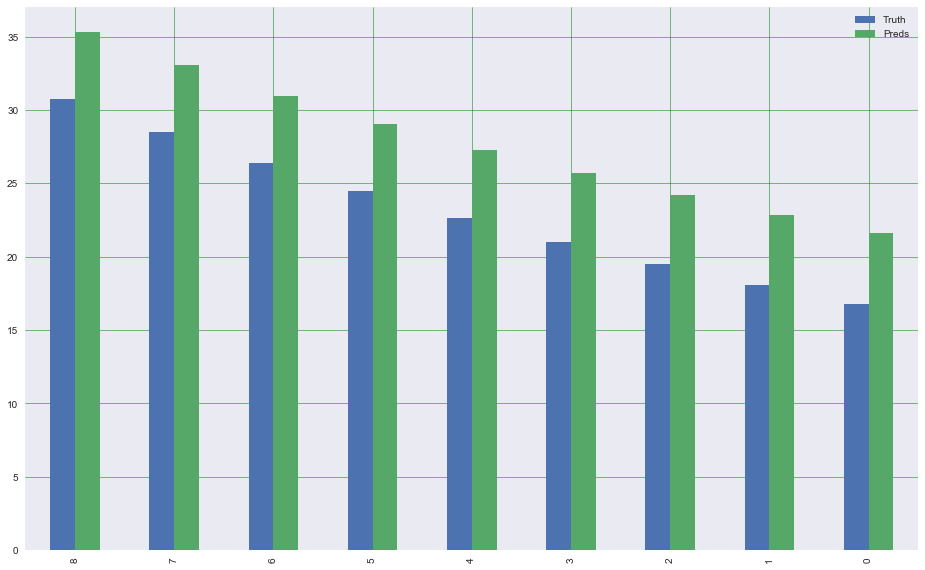

St.Moritz


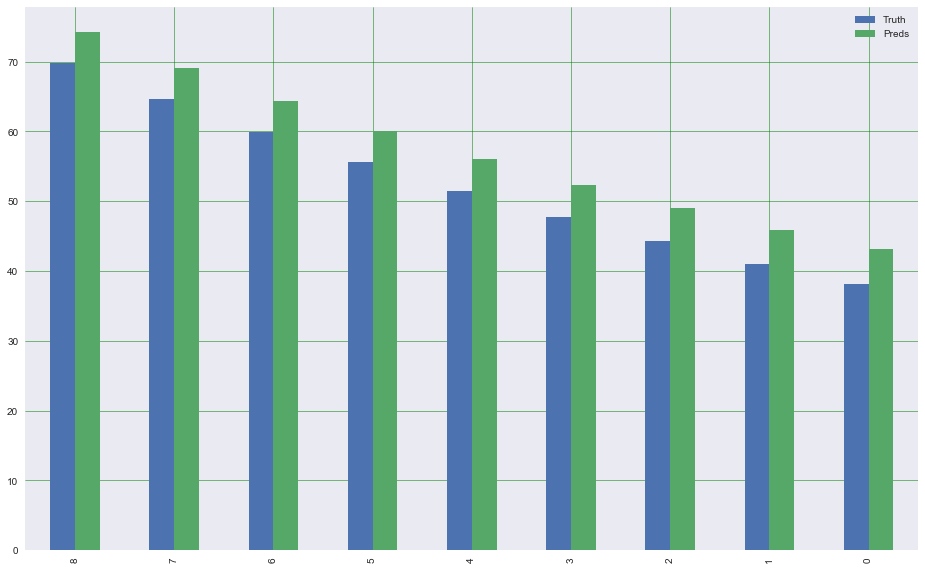

Genoa


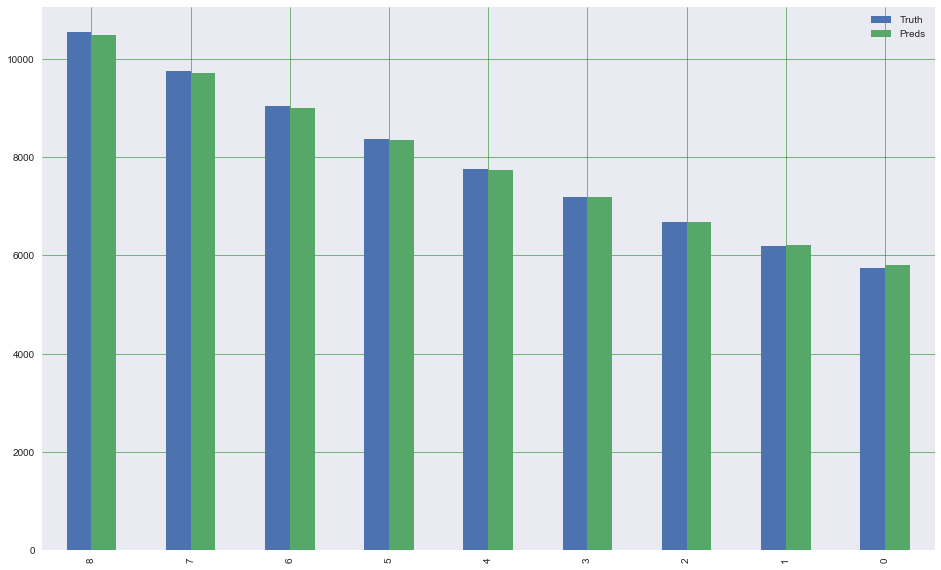

Marseille


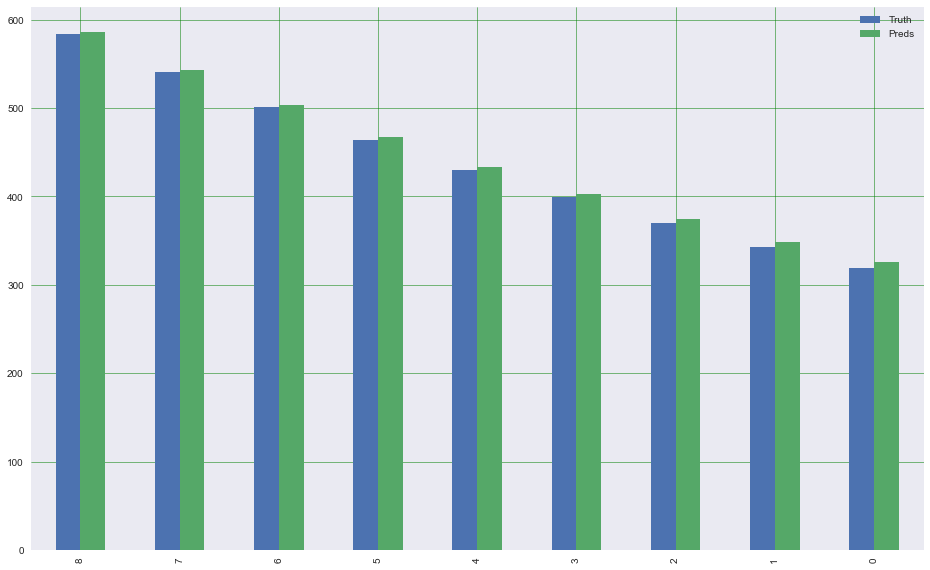

Bayonne


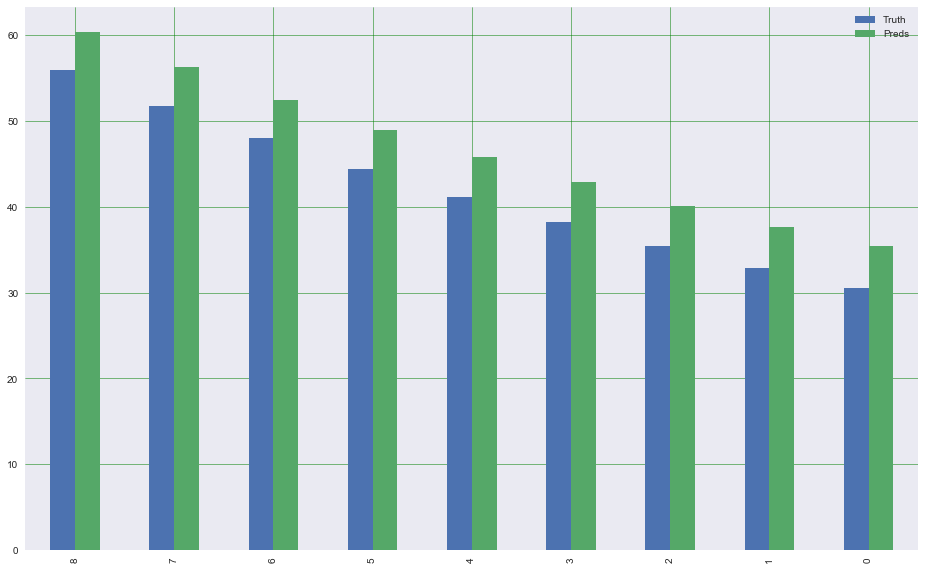

Bordeaux


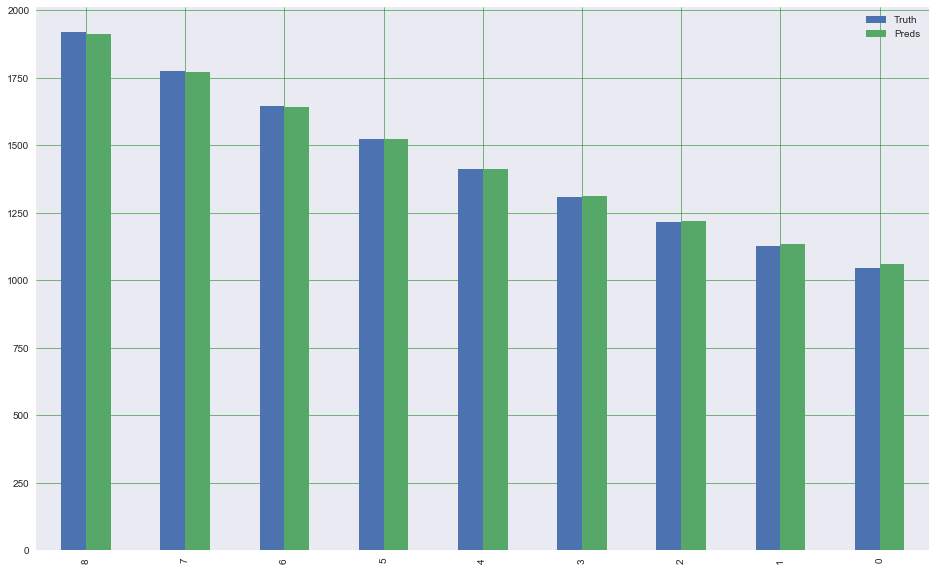

Saint Etienne


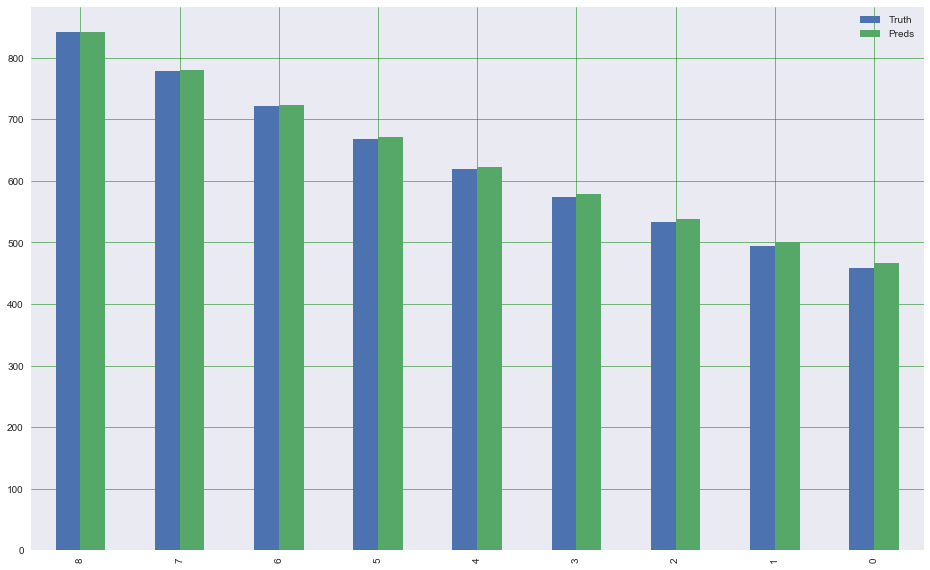

Mailand


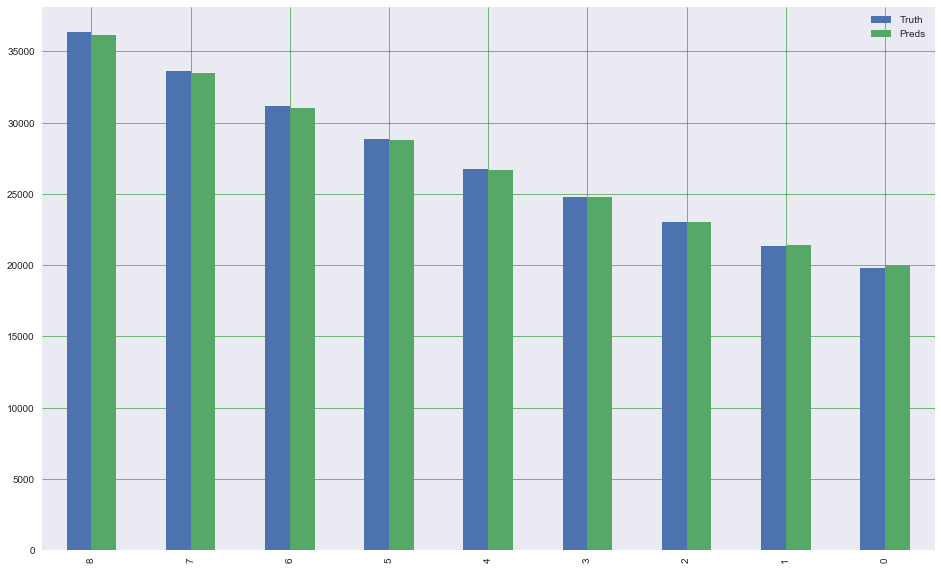

Paris


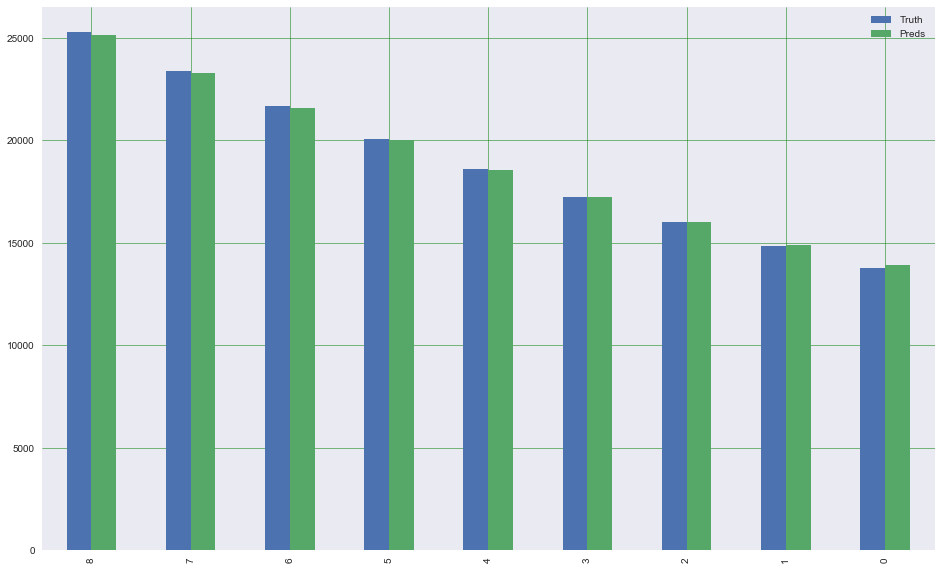

Strasbourg


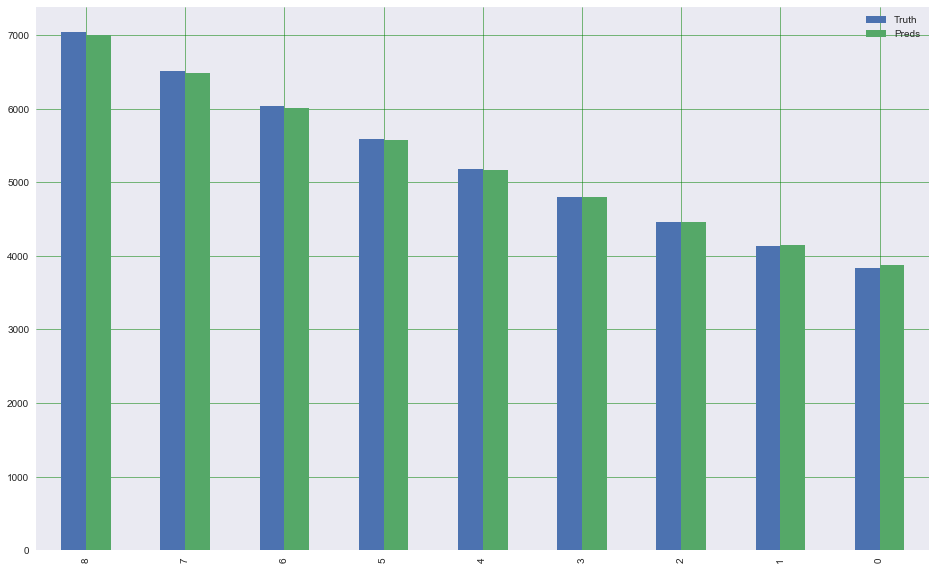

In [7]:
df_city_infected = pd.read_csv('city.csv')

# plot data
for index, row in df_city_infected.iterrows():
    # get city df
    selected_city = row['city']
    print(selected_city)
    df_selected_city = df_city_infected.loc[df_city_infected['city'] == selected_city]
    
    
    # get numpy array per city
    df_numpy = df_selected_city.drop('city', axis=1)
    selected_city_arr = df_numpy.to_numpy()[0]
    selected_city_test_x, selected_city_test_y = create_dataset(selected_city_arr[0:20], OPTIMAL_WINDOW)
    
    # predict per city
    selected_city_predictions = lr_model.predict(selected_city_test_x)

    selected_city_test_dic = {}
    selected_city_test_dic["Truth"] = selected_city_test_y
    selected_city_test_dic['Preds'] = selected_city_predictions
    selected_city_test_df = pd.DataFrame(selected_city_test_dic)
    
    df_selected_city = selected_city_test_df.sort_values(by=['Truth', 'Preds'], ascending=False)
    df_selected_city.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()